**DI LUO**

Spring 2020

CS 251: Data Analysis and Visualization

Project 5: Clustering

In [53]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import multivariate_normal

import kmeans
import em

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 5) EM Algorithm

### 5a) Implement multivariate Gaussian (`gaussian`)

**LA section:** Implement from scratch (i.e. using common numpy math functions and `np.linalg.det` and `np.linalg.inv`)

**Non-LA section:** Make a wrapper for Scipy stats multivariate normal pdf function.

In [54]:
# Test 1: 2D data
np.random.seed(0)
test_xy = np.random.randn(5,2)
test_mu = np.random.uniform(size=(2,))
test_sigma = np.array([[2, 1.5], [1.5, 2]])

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_xy, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.06237 0.02907 0.00424 0.08301 0.08269]')

Your Gaussian PDF evaluated that the test points:
[0.06237 0.02907 0.00424 0.08301 0.08269]
It should be
[0.06237 0.02907 0.00424 0.08301 0.08269]


In [55]:
# Test 2: 4-dimensional data
np.random.seed(0)
test_10 = np.random.randn(5,4)
test_mu = np.random.uniform(size=(4,))
test_sigma = np.random.uniform(size=(4,4))
test_sigma = test_sigma.T @ test_sigma

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_10, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.      0.      0.      0.13288 0.     ]')

Your Gaussian PDF evaluated that the test points:
[0.      0.      0.      0.13288 0.     ]
It should be
[0.      0.      0.      0.13288 0.     ]


### 5b) Implement EM algorithm

Implement each of the following core methods in `em.py`. 

- `initialize`: Initialize cluster means, variance, and the probability that data samples belong to each of the clusters.
- `e_step`: Expectation step of EM algorithm. Compute probability each datapoint belongs to each cluster.
- `m_step`: Maximization step of EM algorithm. Compute each Gaussian cluster's mean and covariance matrix based on data assigned to each cluster.
- `log_likelihood`: Used in EM to monitor clustering progress and detect convergence. Log of sum of probabilities of all data points assigned to all clusters.
- `cluster`: Method that runs EM algorithm.

**E-Step equations:**

Compute the *responsibilities* ($w_{ci}$): the probability that data sample $i$ belongs to cluster $c$.

It can be computed in two stages: Determine $\hat{w}_{ci}$ then ${w}_{ci}$. $$\hat{w}_{ci} = \pi_c \times G\left (\mathbf{data}, \vec{\mu}_c, \mathbf{\Sigma_c}  \right )$$ Above, $\pi_c$ is the proportion of data samples that are associated with cluster $c$ (more on this below), $G(\cdot,\cdot,\cdot)$ is a multivariate Gaussian (representing cluster $c$), $\vec{\mu}_c$ is the mean (*centroid*) of that Gaussian cluster $c$, and $\mathbf{\Sigma_c}$ is the covariance matrix for cluster $c$.$${w}_{ci} = \frac{\hat{w}_{ci}}{\sum_{d=1}^{k}\hat{w}_{di}}$$


**M-Step equations:**

The job of the M-step is to compute the Gaussian cluster centroids ($\vec{\mu}_c$), Gaussian cluster covariance matrices ($\mathbf{\Sigma}_c$), and proportion of data samples that are associated each cluster ($\pi_c$).

$\pi_c$ is the average responsibility of all data samples with respect to each cluster $c$: $$\pi_c = \frac{1}{N}\sum_{j=1}^N w_{cj}$$
Note that above $N$ is the number of data samples. $$\vec{\mu}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \times \vec{\text{data}}_j $$
Above $R_c$ is defined as the sum of the responsibilities of all data samples belonging to one cluster: $R_c = \sum_{j=1}^N {w}_{cj}$.

Finally, the covariance of each cluster $\mathbf{\Sigma}_c$ is computed as: $$\mathbf{\Sigma}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \left ( \vec{\text{data}}_j - \vec{\mu}_c \right )^T \left ( \vec{\text{data}}_j - \vec{\mu}_c \right ) $$
where above $T$ indicates transpose.

**Log-likelihood:**

$$ll = \sum_{i=1}^N Log \left [\sum_{c=1}^k \pi_c f_c \left ( \vec{x}_i; \vec{\mu}_c, \Sigma_c \right ) \right]$$

where $f_c(\cdot)$ is the Gaussian distribution.

#### Test `e_step` (and `initialize`)

In [56]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initialize(test_k)
test_probs = em_test.e_step()
print(f'After 1 E step, your test responsibilities are:\n{test_probs}\nand should be:\n[[0.88106 0.11894 0.99024 0.91517 0.62642]\n\
 [0.11894 0.88106 0.00976 0.08483 0.37358]]')

After 1 E step, your test responsibilities are:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]
and should be:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]


#### Test `m_step`

In [57]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initialize(test_k)
em_test.e_step()
test_m, test_s, test_pi = em_test.m_step()

print(f'After 1 EM iteration, your means are\n{test_m}\n')
print(f'After 1 EM iteration, your covariance matrix is\n{test_s}\n')
print(f'After 1 EM iteration, your pi array is\n{test_pi}\n')

After 1 EM iteration, your means are
[[ 1.22452 -0.06511]
 [ 0.77131  1.46643]]

After 1 EM iteration, your covariance matrix is
[[[ 0.52278 -0.22681]
  [-0.22681  0.50843]]

 [[ 0.3101   0.21107]
  [ 0.21107  0.92664]]]

After 1 EM iteration, your pi array is
[0.70637 0.29363]



The above test should output:

    After 1 EM iteration, your means are
    [[ 1.22452 -0.06511]
     [ 0.77131  1.46643]]

    After 1 EM iteration, your covariance matrix is
    [[[ 0.52278 -0.22681]
      [-0.22681  0.50843]]

     [[ 0.3101   0.21107]
      [ 0.21107  0.92664]]]

    After 1 EM iteration, your pi array is
    [0.70637 0.29363]

#### Test `log_likelihood`

In [58]:
print(f'After running 1 EM iteration (above test code), your likelihood is\n{em_test.log_likelihood()}\nand it should be\n-11.394389039914211')

After running 1 EM iteration (above test code), your likelihood is
-11.39438903991421
and it should be
-11.394389039914211


#### Test `cluster`

Use pandas to load in the `super_simple` dataset. Assign it to the variable `super_simple` then run the following test code to create a plot of your Gaussian clusters. It should look like the following image.

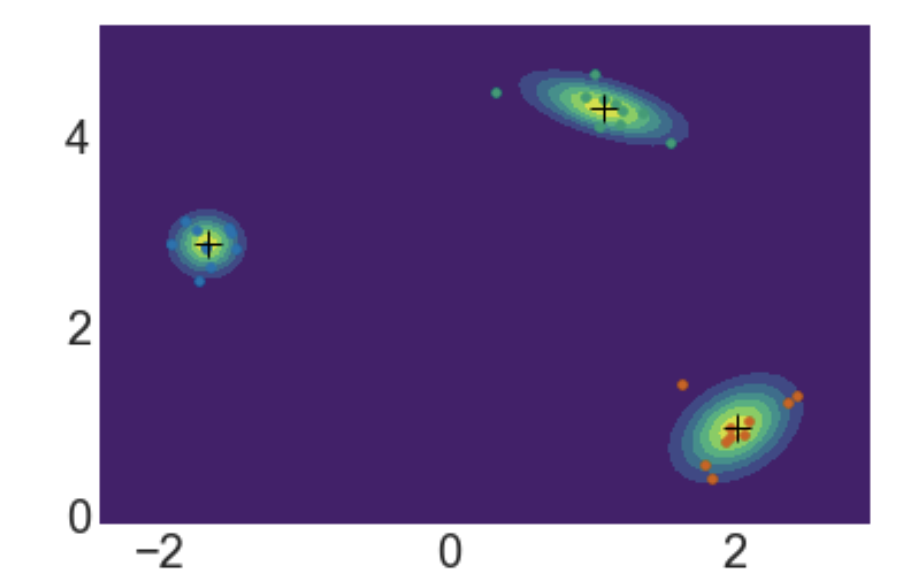

Number of iteration is 3.


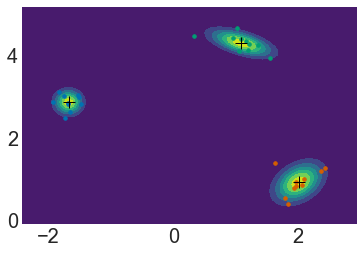

In [59]:
np.random.seed(0)

df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)

simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=True)
simple_test.plot_clusters(super_simple)

### 5c) EM algorithm animation visualization

- Add an optional parameter to `EM::cluster` called `animate`. By default, make it set to False.
- In the main EM loop, after performing a full iteration of EM, call the `plot_clusters` method (if `animate` is true). Immediately before your method call, add the code: `clear_output(wait=True)`. Immediately after, add the code: `plt.pause(0.1)` (The parameter, 0.1 in this case, is the wait time in seconds between plot updates in the animation).

Running this test code, should produce a (**very cool**) animation showing the EM algorithm unfolding over time. You should see if overcome a challenging initial condition.

Here is an image of what the final clustering should look like:

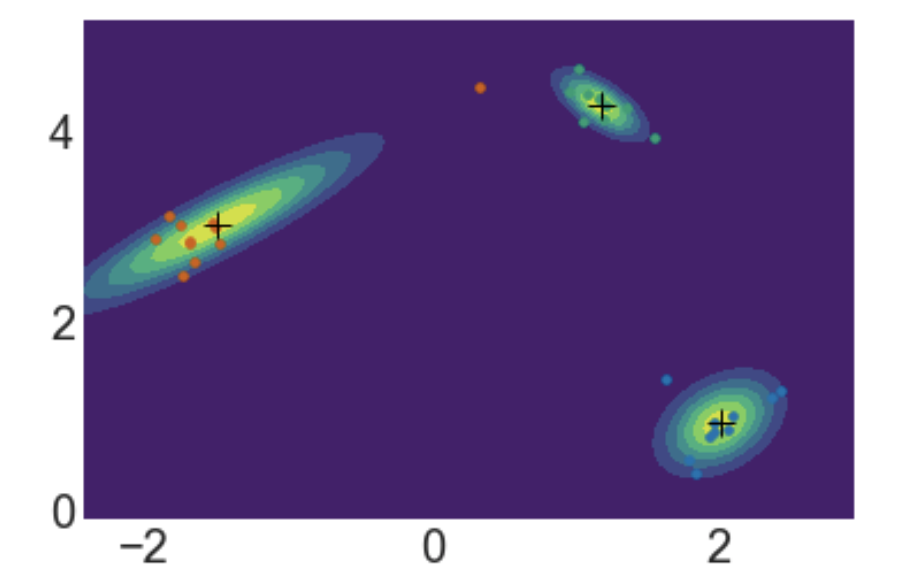

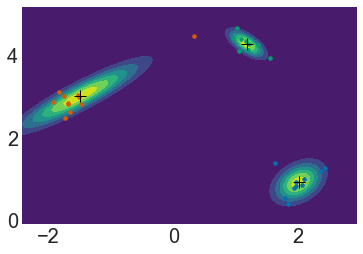

Number of iteration is 25.


In [60]:
np.random.seed(4)

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, animate=True);

### 5d) Outlier detection with EM algorithm

Because the EM algorithm computes the probability that each data sample belongs to each cluster, it can be used to detect outliers in the dataset.

- Implement `find_outliers` in `em.py`.
- Run the following code to find outliers in the `super_simple` dataset (defined as samples belonging to a cluster that have probability < 0.5 here).

In [61]:
# Find outliers in all 3 clusters
outliers = simple_test.find_outliers(thres=0.5)
print(f'Sample indices of your outliers are\n{outliers}\nand they should be\n[(array([], dtype=int64),), (array([ 0, 17]),), (array([20, 26]),)]')

Sample indices of your outliers are
[array([20, 26]), array([], dtype=int64), array([ 0, 18, 28])]
and they should be
[(array([], dtype=int64),), (array([ 0, 17]),), (array([20, 26]),)]


- In the cell below, superimpose a plot on the cluster plot, indicating the outliers that you found with star markers (make them large so that they stand out). It should look like the following image:

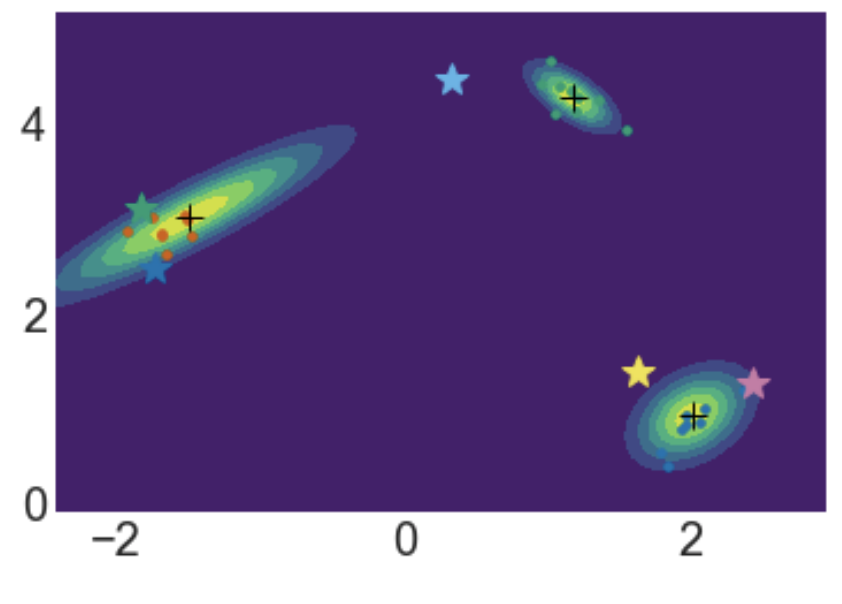

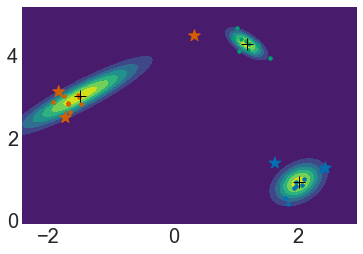

In [62]:
simple_test.plot_clusters(super_simple, show=False)

# Your code here
for i in outliers:
    data = simple_test.data[i]
    plt.scatter(data[:,0], data[:,1], marker='*', s=[150 for j in range(len(i))])
    

## Task 6) Cluster a dataset of your choice with EM algorithm

- Select a 2D dataset (one we've worked with before or a new one of your choice).
    - You may select a higher dimensional dataset, but only run EM on 2 variables **that make sense (see next item)**
    - You may select a higher dimensional dataset and run PCA to reduce the dimensionality to 2D.
- Formulate a question (see question below) that could be addressed by cluster analysis.
- Import/preprocess to prepare the data for clustering by the EM algorithm.
- Analyze the data. Minimally, this should include:
    - Select a k that makes sense to you (you may explore this more rigorously as an extension).
    - Plot of the 2D data clustered.
    - Detect and show outliers
    - Report the final log likelihood of the clustering.

**Question 5:** What dataset did you select for clustering?

**Answer 5:** I select iris.csv, which is the dataset that we worked on during the journey of CS251 project.

**Question 6:** Which two variables did you select for clustering? What question are you exploring, which you believe could be addressed by a cluster analysis?

**Answer 6:** petal_width and petal_length. The question is how many types of petal are there in iris flower (indicated by clustering) and what is the distribution of different types of iris flower's petals.

**Question 7:** What is your interpretation of what the outliers that you detected mean in the context of your dataset?

**Answer 7:** The outliers are the petals that are different from average value in their group/cluster (in other words, they are abnormal).

In [63]:
df = pd.read_csv('data/iris.csv')

df.head(5)

,sepalLength,sepalWidth,petalLength,petalWidth,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


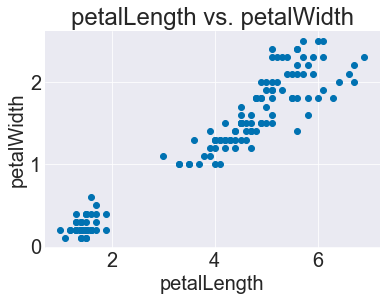

In [64]:
petal_data = df[['petalLength', 'petalWidth']].to_numpy()
plt.scatter(petal_data[:,0], petal_data[:,1])
plt.title('petalLength vs. petalWidth')
plt.xlabel('petalLength')
plt.ylabel('petalWidth')
plt.show()

The scatter plot above shows that there are generally two types of petal for iris flower, one with small length and width and the other with these two being larger. So in this case, I select k as 2.

Number of iteration is 27.


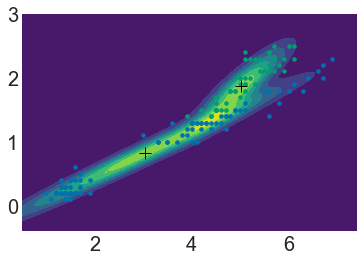

In [65]:
petal_em = em.EM(petal_data)
petal_em.cluster(k=2)
petal_em.plot_clusters(petal_data)

The clustering is shown above, in which the 2 clusters validates that there are 2 kinds of petal for iris flower. Next step is to find outliers. The outliers are shown as stars in the picture below.

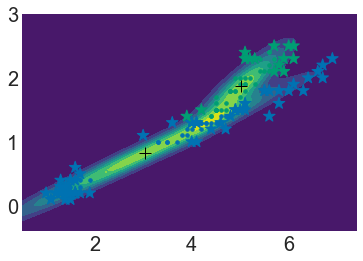

In [66]:
outliers = petal_em.find_outliers(thres=0.5)
petal_em.plot_clusters(petal_data, show=False)

# Your code here
for i in outliers:
    data = petal_em.data[i]
    plt.scatter(data[:,0], data[:,1], marker='*', s=[150 for j in range(len(i))])

Eventually I calculate the final log likelihood of the clustering.

In [67]:
ll = petal_em.log_likelihood()
print(f'The final log likelihood of the clustering of iris.csv\'s petal data is {ll}.')

The final log likelihood of the clustering of iris.csv's petal data is -218.74579573292465.


## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Make an `elbow_plot` for EM algorithm

- Test out and explain results of your `elbow_plot` method on a dataset.

NOTE: Log likelihood is negative and higher is better. Factor this into your interpretation.

I created elbow_plot() functions in em.py. The result below testing on simple_test shows that as the number of iterations increases, log likelihood increases (less negative). This proves that the clustering is being optimized. One thing to point out is that I ran the code below many times and each time gives different results to number of iterations. Sometimes 3, sometimes 8. But their shapes are almost the same, that number of iterations is positively proportional to log likelihood.

Number of iteration is 16.


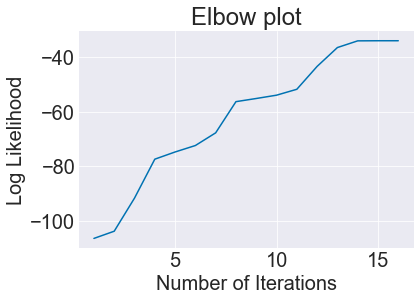

In [52]:
df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()
simple_k = 3
simple_test = em.EM(super_simple)
simple_test.cluster(k=simple_k, max_iter=100, verbose=False)
simple_test.elbow_plot()

The case above has number of iteration as 16, where as the case below is 3. This shows that the variance of the result is high, and the result is unstable.

Number of iteration is 3.


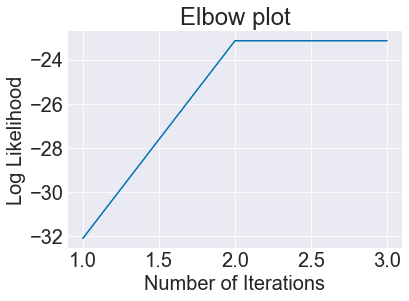

In [50]:
simple_test.cluster(k=simple_k, max_iter=100, verbose=False)
simple_test.elbow_plot()

### 2) Better initial conditions

- EM has the same centroid initialization problem as K-means. Implement a version of K-means++ initialization for EM. Analyze the differences vs. the random initialization scheme.

I copied two distance functions dist_pt_to_pt() and dist_pt_to_centroids() from kmeans.py to em.py, and also initialize_plusplus(). Then I tested clustering with k++, and find that k++ makes the result more stable. I ran the code below many times and the number of iterations mostly stays 3 with very few expections over 10. Compared with random initialization scheme, where the result of num of iterations keeps varying from 3 to 16, k++ initialization scheme gives more stable result as it spreads out the initialized centroids.

Number of iteration is 3.


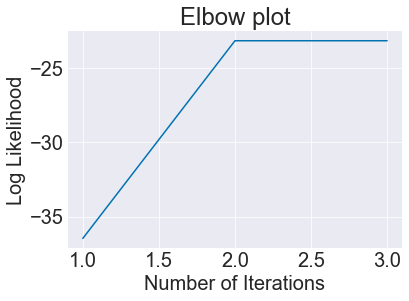

In [71]:
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, method='kmeans++')
simple_test.elbow_plot()